# Exploitation features histogrammes

### Import des librairies

In [ ]:
! pip install imageio
! pip install opencv-python

In [ ]:
import cv2
import os
from imageio import imread
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import svm, grid_search, datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import csv

### Initialisation des variables

In [0]:
data = pd.read_csv('df_histo.csv',delimiter='§',engine='python')

In [0]:
data.sort_values(by=['Unnamed: 0'],inplace=True)
index = data['Unnamed: 0']
del data['Unnamed: 0']

In [0]:
annotations = pd.read_csv('Annotations3.csv')

### Définition des fonctions

#### Fonction de création du graphique

In [0]:
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, plot, iplot
import numpy as np

def plot_cluster(coords, names, labels, name_plot):
    ''' 
    Create a scatter plot
    
    Arguments:
        coords {numpy array} -- A numpy array with N lines and 2 columns 
                                (N=number of individuals) each column 
                                correspond to a dimension
        names {list} -- list corresponding to the names of the individuals
        labels {type} -- Label of the cluster (an integer like 0 for the first cluster, 1 for the second...)
        name_plot {str} -- name of the html file of the plot
    '''

    # Create a trace
    trace = go.Scatter(
        x = coords[:, 0],
        y = coords[:, 1],
        mode = 'markers',
        text = names,
        marker = dict(
            size = 10,
            color = labels,
            line = dict(
                width = 2,
                color = 'rgb(102, 102, 255)'
            )
        )
    )

    data = [trace]

    layout = dict(title = 'Styled Scatter',
                    yaxis = dict(zeroline = False),
                    xaxis = dict(zeroline = False)
                    )

    fig = dict(data=data, layout=layout)
    plot(fig, filename=name_plot)

#### Fonction de création de la matrice de confusion

In [0]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.grid("off")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

#### Fonction de stratification de l'échantillon

In [0]:
from random import sample
import random

def splits(X,y):
    random.seed(1)
    index = list(y.index[y == 1])
    nb_elem_test = int(len(index)*0.2)
    print(len(index))
    index_train = sample(index, nb_elem_test)
    index_test = list(set(index) - set(index_train))

    # les non violents
    index_not = list(set(y.index) - set(index))

    index_not_train = sample(index_not, nb_elem_test)
    index_not_test = list(set(index_not) - set(index_not))

    # assemblage
    index_train = index_train + index_not_train
    index_test = list(set(y.index) - set(index_train))

    # y_violent[y_violent.index == index_test]
    X_train = X[y.index.isin(index_train)]
    X_test = X[y.index.isin(index_test)]
    y_train = y[y.index.isin(index_train)]
    y_test = y[y.index.isin(index_test)]
    
    print(len(X_train))
    print(len(X_test))
    print(len(y_train))
    print(len(y_test))
    
    return X_train,X_test,y_train,y_test

#### Fonction pour exécuter KNN

In [0]:
def KNN_plus_gridsearch(X, y, n_neighbors_knn, n_neighbors_grid,c1,c2,title):

    #KNN
    # split and shuffle X and y
    #TEST_SIZE = np.int(np.floor(len(y)*0.3))
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE)
    X_train,X_test,y_train,y_test = splits(X,y)
    
    # train
    n_neighbors = n_neighbors_knn
    clf = KNeighborsClassifier(n_neighbors)
#     clf = SVC()
    #TODO: fit le modèle 1 seule fois
    
    # GRID SEARCH
    # parameters
    myList = list(range(1,n_neighbors_grid))
#     n = filter(lambda x: x % 2 != 0, myList)
    parameters = {'n_neighbors':myList}

    # learn with grid search
    model = GridSearchCV(clf, parameters)
    #TODO: fit le modèle 1 seule fois
    model.fit(X_train, y_train)
    
    # le best k trouvé est à priori dans les paramètres
    params = model.best_params_
        
    n_neighbors = params['n_neighbors']
    clf = KNeighborsClassifier(n_neighbors)
    
    clf.fit(X_train, y_train)

    # predict
    #TODO: prédire toujours sur les mêmes vidéos pour pouvoir comparer l'accuracy des prédictions avec différents paramètrages
    y_pred = clf.predict(X_test)
    
    # transform into dataframe
    y_pred = pd.DataFrame(y_pred)
    y_pred.index = y_test.index
    
#     print(y_test)
#     print(y_pred)
    
    df = pd.concat([y_pred, y_test], axis=1)
    df.columns = ['pred', 'test']

    # confusion matrix
    confusion = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(confusion,classes=[c1,c2],title=title)

    #accuracy
    acc = 0
    for i in df.index:
        if (df['test'][i]==df['pred'][i]):
            acc +=1
    acc = acc/len(df)
    
    return df, confusion, acc, params

### KMeans

In [0]:
kmeans_pca = KMeans(n_clusters=2, random_state=0).fit_predict(data)

In [0]:
kmeans_pca

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,

In [0]:
km = pd.DataFrame({'name':index,'classe':kmeans_pca})

### PCA

In [0]:
pca = PCA(n_components=2)
so_data_reduc = pca.fit_transform(data)
print(pca.explained_variance_ratio_) 

[0.36228939 0.1014977 ]


Seulement 46% de variance expliquée par les 2 premiers axes. Il y a donc pleins d'autres explorations possibles sur les données

In [0]:
plot_cluster(so_data_reduc,index,kmeans_pca,'plot.html')

### Evaluation du cluster

In [0]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import pandas as pd


def best_k(X, range_min=25, verbose=True):

    if range_min < 2:
        raise ValueError('range_min is less than 2')
    score = []
    for i, k in enumerate(range(2, range_min)):

        model = KMeans(n_clusters=k, random_state=42, n_init=30)
        score.append(silhouette_score(X, model.fit_predict(X)))
        if verbose:
            print(f'Le score pour k={k} est : {score[i]:.2f}')

    return range(2, range_min)[score.index(max(score))]

In [0]:
best_k(so_data_reduc)

Le score pour k=2 est : 0.60
Le score pour k=3 est : 0.60
Le score pour k=4 est : 0.51
Le score pour k=5 est : 0.52
Le score pour k=6 est : 0.53
Le score pour k=7 est : 0.47
Le score pour k=8 est : 0.47
Le score pour k=9 est : 0.49
Le score pour k=10 est : 0.44
Le score pour k=11 est : 0.44
Le score pour k=12 est : 0.43
Le score pour k=13 est : 0.44
Le score pour k=14 est : 0.43
Le score pour k=15 est : 0.44
Le score pour k=16 est : 0.44
Le score pour k=17 est : 0.44
Le score pour k=18 est : 0.43
Le score pour k=19 est : 0.44
Le score pour k=20 est : 0.43
Le score pour k=21 est : 0.44
Le score pour k=22 est : 0.44
Le score pour k=23 est : 0.43
Le score pour k=24 est : 0.43


3

In [0]:
exterieur = []
for i in range(len(km['name'])):
    for j in range(len(annotations['Sequence'])-2):
        if annotations['Sequence'][j] in km['name'][i]:
            exterieur.append(int(annotations['Exterieur'][j]))

In [0]:
violent = []
for i in range(len(km['name'])):
    for j in range(len(annotations['Sequence'])-2):
        if annotations['Sequence'][j] in km['name'][i]:
            violent.append(int(annotations['Violent'][j]))

In [0]:
sombre = []
for i in range(len(km['name'])):
    for j in range(len(annotations['Sequence'])-2):
        if annotations['Sequence'][j] in km['name'][i]:
            sombre.append(int(annotations['Sombre'][j]))

In [0]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(list(km['classe']),exterieur)
cf_matrix_violent = confusion_matrix(list(km['classe']),violent)
cf_matrix_sombre = confusion_matrix(list(km['classe']),sombre)

### Matrices de confusion

Confusion matrix, without normalization
[[ 60  19]
 [137  92]]


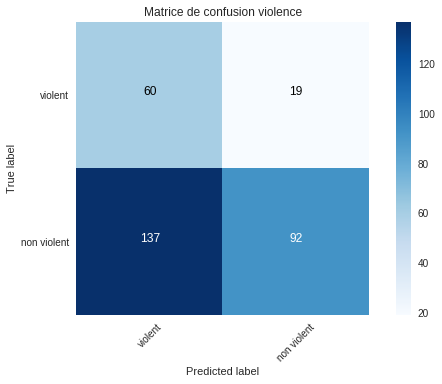

In [0]:
plot_confusion_matrix(cf_matrix,classes=['violent','non violent'],title='Matrice de confusion violence')

Confusion matrix, without normalization
[[ 65  14]
 [185  44]]


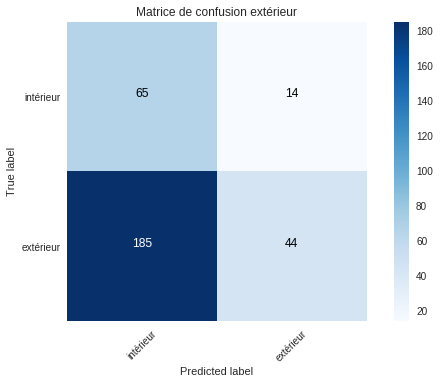

In [0]:
plot_confusion_matrix(cf_matrix_violent,classes=['intérieur','extérieur'],title='Matrice de confusion extérieur')

Confusion matrix, without normalization
[[ 27  52]
 [196  33]]


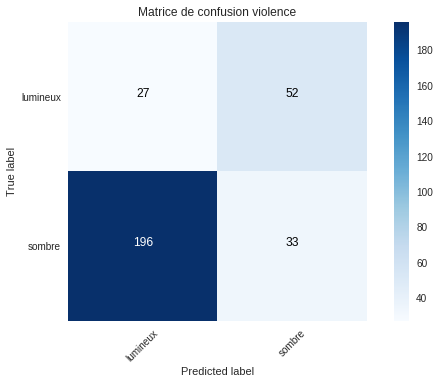

In [0]:
plot_confusion_matrix(cf_matrix_sombre,classes=['lumineux','sombre'],title='Matrice de confusion violence')

Lumineux : 200/245 = 0.81

Sombre : 40/63 = 0.63

On a une plutôt bonne classification selon sombre/lumineux.

58
22
286
22
286
Confusion matrix, without normalization
[[109 130]
 [ 28  19]]
{'n_neighbors': 5}
accuracy: 0.44755244755244755


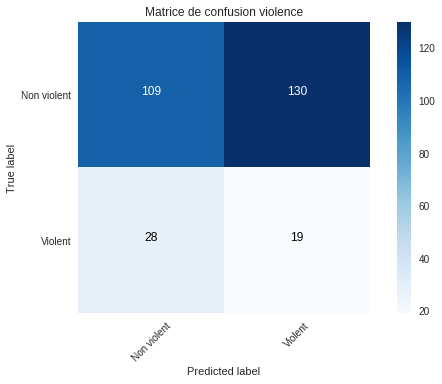

In [0]:
# get in/out classification
y_inout = pd.read_csv('Annotations2.csv')["Violent"]
#TODO: rédoudre bug
df, confusion, acc, params= KNN_plus_gridsearch(so_data_reduc, y_inout[0:308], 3, 10,'Non violent','Violent','Matrice de confusion violence')
print (params)
# print (confusion)
print(f"accuracy: {acc}")

85
34
274
34
274
Confusion matrix, without normalization
[[168  38]
 [ 18  50]]
{'n_neighbors': 8}
accuracy: 0.7956204379562044


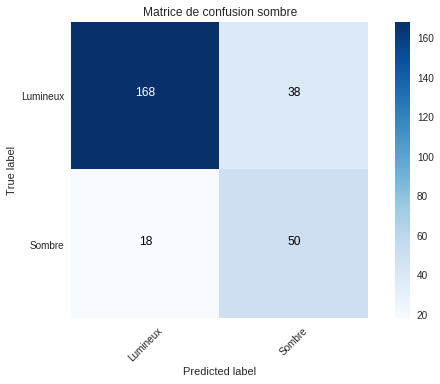

In [0]:
# get in/out classification
y_inout = pd.read_csv('Annotations3.csv')["Sombre"]
#TODO: rédoudre bug
df, confusion, acc, params= KNN_plus_gridsearch(so_data_reduc, y_inout[0:308], 8, 10,'Lumineux','Sombre','Matrice de confusion sombre')
print (params)
# print (confusion)
print(f"accuracy: {acc}")